In [30]:
%load_ext autoreload
%autoreload 2

import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test of Radiation solver

In [15]:

nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=10000.0))
A, stimulated_emission_rate, absorbtion_rate = nlte_solver.processes[1].get_einstein_rates()
i23S = nlte_solver.states.all_names.index("23S")
i23P = nlte_solver.states.all_names.index("23P")

print("A rates ordered correctly:", A[i23S, i23P] > 0 and A[i23P, i23S] == 0)
print("Absorbtion rates ordered correctly:", absorbtion_rate[i23S, i23P] == 0 and absorbtion_rate[i23P, i23S] > 0)
print("Stimulated rates ordered correctly:", stimulated_emission_rate[i23S, i23P] > 0 and stimulated_emission_rate[i23P, i23S] == 0)
print("g factor correct:", np.isclose(absorbtion_rate[i23P, i23S]/stimulated_emission_rate[i23S, i23P],3))

pop_frac = lambda x: x[0]/sum(x)
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=1000.0))
print("Low temperature limit correct: ", 0.99 < pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1])) # All in lower state
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=10000.0)) # Approaching T->inf
print("High temperature limit correct: ", 0.8 > pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1]))

A rates ordered correctly: True
Absorbtion rates ordered correctly: True
Stimulated rates ordered correctly: True
g factor correct: True
Low temperature limit correct:  True
High temperature limit correct:  True


In [19]:
states = NLTE.NLTE_model.States()
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=10000.0), states=states)
A, stimulated_emission_rate, absorbtion_rate = nlte_solver.processes[1].get_einstein_rates()
i23P = nlte_solver.states.all_names.index("23P")
i33S = nlte_solver.states.all_names.index("33S")

print("A rates ordered correctly:", A[i23P, i33S] > 0 and A[i33S, i23P] == 0)
print("Absorbtion rates ordered correctly:", absorbtion_rate[i23P, i33S] == 0 and absorbtion_rate[i33S, i23P] > 0)
print("Stimulated rates ordered correctly:", stimulated_emission_rate[i23P, i33S] > 0 and stimulated_emission_rate[i33S, i23P] == 0)
print("g factor correct:", np.allclose(absorbtion_rate[i33S, i23P]/stimulated_emission_rate[i23P, i33S], 1/3))

pop_frac = lambda x: x[0]/sum(x)
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=1000.0), states=states)
print("Low temperature limit correct: ", 0.99 < pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1])) # All in lower state
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=10000.0), states=states) # Approaching T->inf
print("High temperature limit correct: ", 0.8 > pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1]))

A rates ordered correctly: True
Absorbtion rates ordered correctly: True
Stimulated rates ordered correctly: True
g factor correct: True
Low temperature limit correct:  True
High temperature limit correct:  True


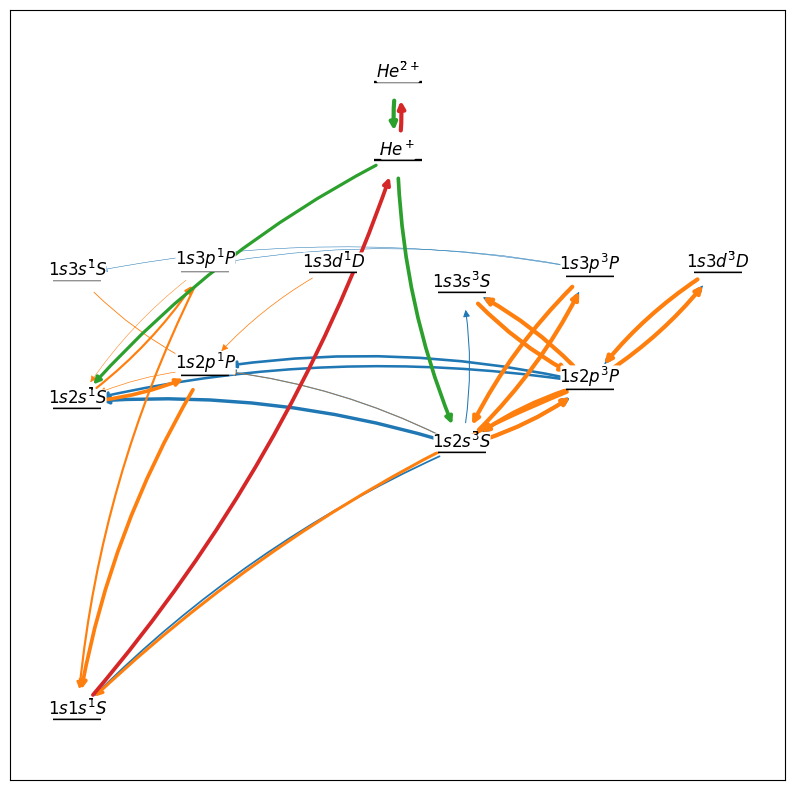

[19.81961452 20.96408689 22.71846642 23.00707315 23.07365071] eV
[1.58843284e+00 1.19376525e-01 1.95633457e-04 5.32321650e-04
 3.82180158e-04]


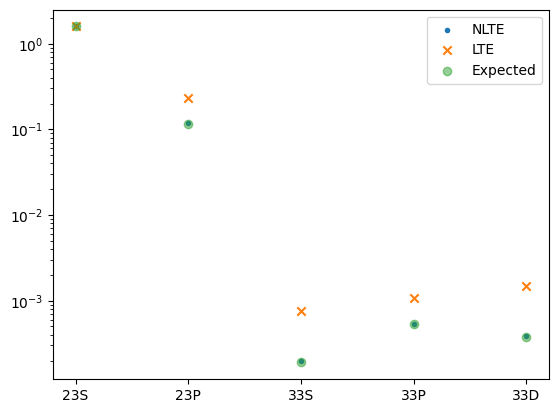

In [21]:
import networkx as nx


states = NLTE.NLTE_model.States()
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=4400.0), states=states)
rad_process = nlte_solver.processes[1]
nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
idx_of = lambda x: nlte_solver.states.all_names.index(x)
min_rate = 0.01
max_rate = 1e2
max_width = 3
for a,b in [("33S", "33P"), ("33P", "33D"), ("21P", "33D"), ("31D", "23P")]:
    idx_a = idx_of(a)
    idx_b = idx_of(b)
    rad_process.A[idx_a, idx_b] = 0
    rad_process.A[idx_b, idx_a] = 0
    rad_process.arbsorbtion_rate[idx_a, idx_b] = 0
    rad_process.arbsorbtion_rate[idx_b, idx_a] = 0
    rad_process.stimulated_emission_rate[idx_a, idx_b] = 0
    rad_process.stimulated_emission_rate[idx_b, idx_a] = 0

plt.figure(figsize=(10,10))
ax = plt.gca()        
t, y = nlte_solver.solve(1e6)

for i, process in enumerate(nlte_solver.processes):
        process_fluxes = (process.get_transition_rate_matrix() * y.T[-1][None,:]).T

        # give nodes the names states.names + ["HeII", "HeIII"]
        widths = np.interp(np.log10(np.maximum(process_fluxes, min_rate)), np.log10([min_rate, max_rate]), [0, max_width])
        widths = widths * (widths >= 0.3)
                #np.log10([min_rate, max_rate]), [0, max_width], np.log10(process_fluxes)
        #widths = np.clip(np.log10(process_fluxes/max_flux)+dynamic_range, 0, 10)/dynamic_range*3
        #widths = np.clip(process_fluxes/max_flux * 5, 0, 10)
        G = nx.DiGraph(widths)
        # rename nodes:
        labels = {i:name for i, name in enumerate(np.array(nlte_solver.states.all_names))}
        G = nx.relabel_nodes(G, labels)
        weights = nx.get_edge_attributes(G,'weight').values()
        x_pos = {"11S": 0,  "21S": 0,   "31S": 0,
                            "21P": 1,   "31P": 1, 
                                        "31D": 2, 
                            "23S": 3,   "33S": 3,
                            "23P": 4,   "33P": 4, 
                                        "33D": 5, 
                }
        final_pos = {name: (x_pos[name], energy.value) for name, energy in zip(nlte_solver.states.all_names, nlte_solver.states.energies)} 
        final_pos["HeII"] = (2.5, 25.1) # add HeII and HeIII
        final_pos["HeIII"] = (2.5, 26.5)
        final_pos["11S"] = 0, 15      # modify 11S
        labels = {name: f"$1s{name[0]}{name[2].lower()}^{name[1]}{name[2]}$" for name in nlte_solver.states.names}
        labels["HeII"] = "$He^+$"
        labels["HeIII"] = "$He^{2+}$"
        #pos = nx.circular_layout(G)
        #nx.draw(G, final_pos, ax=ax,
        #        width=list(weights), edge_color=f'C{i}' ,connectionstyle="arc3,rad=0.1",
        #        with_labels=True, labels=labels, 
        #        node_color='k', node_shape="_", node_size=1200, font_size=10, font_weight="light", 
        #        verticalalignment="bottom", 
        #        bbox=dict(facecolor=ax.get_facecolor(), edgecolor = ax.get_facecolor(), boxstyle='square,pad=-0.1'))
        nx.draw_networkx_edges(G, {name: np.array([0,0.1])+final_pos[name] for name in final_pos}, ax=ax, width=list(weights), edge_color=f'C{i}', node_size=1200 ,connectionstyle="arc3,rad=0.1",)
        nx.draw_networkx_nodes(G, final_pos, ax=ax, node_color='k', node_shape="_", node_size=1200)
        nx.draw_networkx_labels(G, final_pos, ax=ax, labels=labels, font_weight="light", verticalalignment="bottom",
                                bbox=dict(facecolor=ax.get_facecolor(), edgecolor = ax.get_facecolor(), boxstyle='square,pad=-0.1'))
        ax.plot([],[], color=f'C{i}', label=f'{process.name}')
plt.show()
y = nlte_solver.solve(1e6)[1][:,-1]
ortho_filter = np.array([name[-2] == "3" for name in states.all_names])
plt.scatter(np.array(states.all_names)[ortho_filter], y[ortho_filter], marker=".", label = f"NLTE");

environment = nlte_solver.environment
bolzman = states.multiplicities * np.exp(-states.energies / (const.k_B * environment.T_phot * u.K))
lte_pop = bolzman[ortho_filter[:-2]] /bolzman[1]  * y[1]
plt.scatter(np.array(states.all_names)[ortho_filter], lte_pop, marker="x", label = f"LTE");
plt.scatter(np.array(states.all_names)[ortho_filter], lte_pop * [1, 1/2, 1/4, 1/2, 1/4], marker="o", alpha=0.5, label = f"Expected");
print(states.energies[ortho_filter[:-2]])
print(y[ortho_filter])
plt.legend()
plt.yscale("log")

# Test of collisional solver

In [32]:
states = NLTE.NLTE_model.States.read_states()
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(), states=states)
nlte_solver.environment.n_e=1e30
y = nlte_solver.solve(1e6)[1][:-2,-1]
#print("High density limit correct: ", 0.5 > pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1]))
p_i = nlte_solver.states.multiplicities * np.exp(-nlte_solver.states.energies / (const.k_B * nlte_solver.environment.T_electrons*u.K))
pop = p_i / sum(p_i) * sum(y)
pop_frac = lambda x: x/sum(x)
print("High density limit correct: ", np.allclose(pop_frac(y), pop_frac(pop)))

[[ 1  3  1  9  3  3  1  9 15  5  3  3  1  9 15  5 21  7  3]]
High density limit correct:  True


In [41]:
y_rows = nlte_solver.processes[0].get_collision_rates()

In [42]:
y_cols = nlte_solver.processes[0].get_collision_rates()

In [37]:
y_rows/y_cols